<a href="https://colab.research.google.com/github/ljrn8/QuickNotebooks/blob/main/blood_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# White Blood Cell Categorization | Keras 
---

thanks to Pual Mooney for the dataset:
https://www.kaggle.com/datasets/paultimothymooney/blood-cells/code?datasetId=9232&sortBy=voteCount

In [ ]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from functools import partial

## Downloading the dataset from kaggle

When reproducing this notebook, a kaggle API token must be located under /content/drive/MyDrive/kaggle.json for it to run. Kaggle API tokens can be downloaded from kaggle.com > sign in > account > create new API token. If your not using colab, ignore these cells and just download the dataset from the link above

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/
!mkdir ~/.kaggle

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s 'blood cells'

ref                                                       title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
paultimothymooney/blood-cells                             Blood Cell Images                              108MB  2018-04-21 21:06:13          32324        766  0.7058824        
saurabhshahane/in-hospital-mortality-prediction           In Hospital Mortality Prediction               136KB  2021-09-03 16:04:57           3811        106  0.9411765        
kmader/malaria-bounding-boxes                             Malaria Bounding Boxes                           4GB  2019-05-09 13:37:54           3349        117  0.75             
alexandervc/single-cell-rna-seq-nestorova2016-mouse-hspc  Single Cell RNA seq Nestorova2016 Mouse HSPC    28MB  202

In [ ]:
!kaggle datasets download -d 'paultimothymooney/blood-cells'

 98% 106M/108M [00:05<00:00, 24.5MB/s]
100% 108M/108M [00:05<00:00, 20.5MB/s]


In [ ]:
!unzip blood-cells.zip > /dev/null 

In [ ]:
!tree /content/dataset2-master/ --filelimit 10

/bin/bash: tree: command not found


## Looking at the data

sample image shape:  (240, 320, 3)


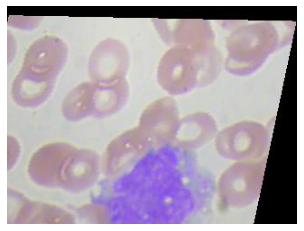

In [ ]:
base_dir = '/content/dataset2-master/dataset2-master/images/'
fname = os.listdir(base_dir + 'TRAIN/MONOCYTE/')[0]
sample_image = plt.imread(base_dir + 'TRAIN/MONOCYTE/' + fname)
print('sample image shape: ', sample_image.shape)
plt.imshow(sample_image)
plt.axis('off')
plt.show()

MONOCYTE


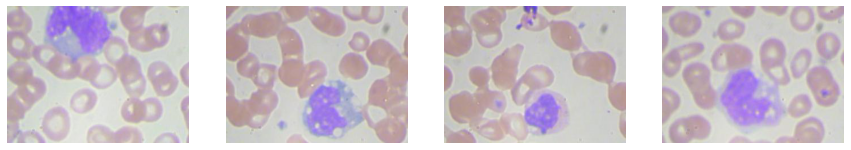

LYMPHOCYTE


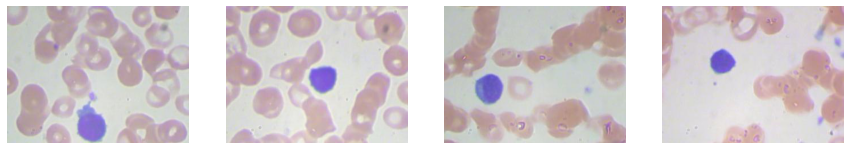

EOSINOPHIL


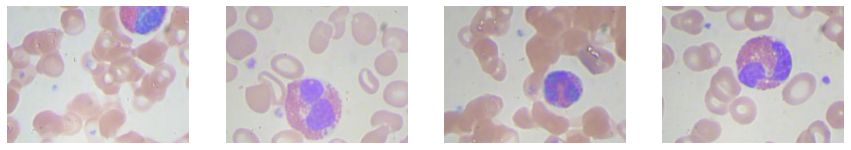

NEUTROPHIL


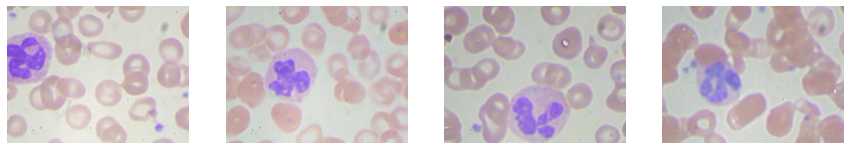

In [ ]:
def peak(path):
    ''' looks at the first 4 images '''
    fig, axs = plt.subplots(1,4, figsize=(15,7))
    for count, (ax, filename) in enumerate(zip(axs, os.scandir(path))):
        image = plt.imread(filename.path)
        ax.imshow(image)
        ax.axis('off')
        if count == 4:
            break
    plt.show()

subcats = ['MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']
for subcat in subcats:
    print(subcat)
    peak(base_dir + 'TEST_SIMPLE/' + subcat + '/')   

## Preprocessing & Setup

In [ ]:
base_dir = '/content/dataset2-master/dataset2-master/images/'

def load_data(preprocess=None, batch=32):
    test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir + 'TEST/', seed=0, batch_size=batch
    )
    valid_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir + 'TRAIN/', seed=0, batch_size=batch,
        validation_split=0.2, subset="validation", 
    )
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir + 'TRAIN/', seed=0, batch_size=batch,
        validation_split=0.2, subset="training", 
    )
    for ds in [train_ds, valid_ds, test_ds]:
        ds = ds.shuffle(1000)
        if preprocess:
            for im_b, _ in ds:
                im_b = preprocess(im_b) # careful of ram 

    return test_ds, train_ds, valid_ds

test_ds, train_ds, valid_ds = load_data()

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(240, 240),
    layers.Rescaling(1./255.),
])

def custom_preprocess(datasets):
    for ds in datasets: 
        ds = ds.shuffle(1000)
        ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                    num_parallel_calls=AUTOTUNE)
        # ds = ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)), num_parallel_calls=AUTOTUNE)
        # ds =  ds.prefetch(buffer_size=AUTOTUNE).cache()
        yield ds

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


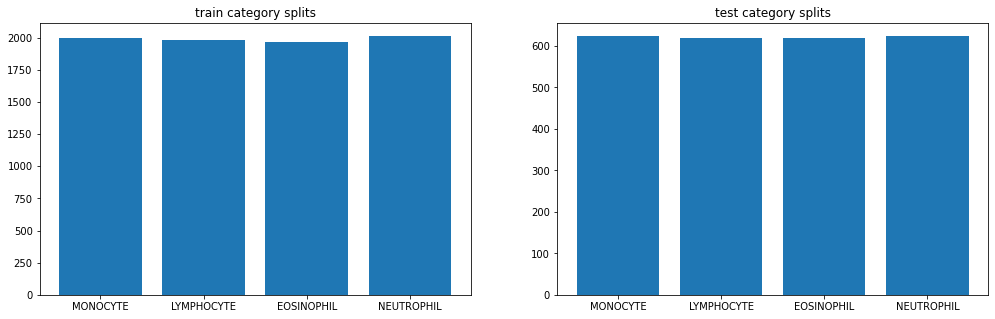

In [ ]:
def plot_categories(ds, categories, ax=plt):
    labels_ds = ds.map(lambda x, y: y)
    labels_np = np.concatenate(list(labels_ds.as_numpy_iterator()))
    uniq, counts = np.unique(labels_np, return_counts=True)
    ax.bar(categories, counts)
    
subcats = ['MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
ax1.set_title('train category splits')
plot_categories(train_ds, subcats, ax=ax1)
ax2.set_title('test category splits')
plot_categories(test_ds, subcats, ax=ax2)
plt.show()    

## InceptionV3

In [ ]:
# using premade models in keras requires inbuilt preprocessing
test_ds, train_ds, valid_ds = load_data(keras.applications.inception_v3.preprocess_input)

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [ ]:
model = keras.applications.InceptionV3(
    include_top=True,
    weights=None, 
    input_shape=[256, 256, 3],
    classes=4,
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4)
history = model.fit(train_ds, epochs=15, callbacks=[early_stopping_cb], validation_data=valid_ds)

Epoch 1/15
249/249 [==============================] - 141s 380ms/step - loss: 1.6103 - accuracy: 0.2556 - val_loss: 61.3338 - val_accuracy: 0.2642
Epoch 2/15
249/249 [==============================] - 89s 355ms/step - loss: 1.2155 - accuracy: 0.4050 - val_loss: 7.4568 - val_accuracy: 0.2431
Epoch 3/15
249/249 [==============================] - 89s 355ms/step - loss: 0.7802 - accuracy: 0.6449 - val_loss: 70.9707 - val_accuracy: 0.2411
Epoch 4/15
249/249 [==============================] - 88s 354ms/step - loss: 0.5149 - accuracy: 0.7808 - val_loss: 1.4292 - val_accuracy: 0.6549
Epoch 5/15
249/249 [==============================] - 89s 356ms/step - loss: 0.3945 - accuracy: 0.8415 - val_loss: 3.0582 - val_accuracy: 0.5640
Epoch 6/15
249/249 [==============================] - 89s 355ms/step - loss: 0.2884 - accuracy: 0.8845 - val_loss: 0.3551 - val_accuracy: 0.8553
Epoch 7/15
249/249 [==============================] - 89s 356ms/step - loss: 0.2494 - accuracy: 0.9032 - val_loss: 2.6751 - val

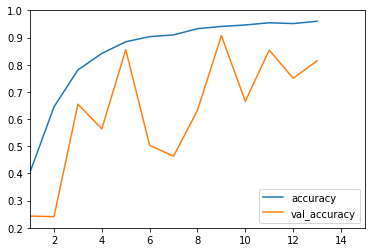

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(xlim=[1, 15], ylim=[0.2, 1])
plt.show()

In [ ]:
model.evaluate(test_ds)

78/78 [==============================] - 8s 98ms/step - loss: 1.7200 - accuracy: 0.7740


[1.7199876308441162, 0.7740249037742615]

## ResNet50V2

In [ ]:
test_ds, train_ds, valid_ds = load_data(keras.applications.resnet_v2.preprocess_input)

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [ ]:
model = keras.applications.ResNet50V2(
    include_top=True,
    weights=None, 
    input_shape=[256, 256, 3],
    classes=4,
)
model.compile(
    optimizer=keras.optimizers.Adam(0.03),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)
history = model.fit(train_ds, epochs=20, callbacks=[early_stopping_cb], validation_data=valid_ds)

Epoch 1/20
249/249 [==============================] - 128s 367ms/step - loss: 1.5254 - accuracy: 0.2985 - val_loss: 57.6762 - val_accuracy: 0.2577
Epoch 2/20
249/249 [==============================] - 88s 353ms/step - loss: 0.9323 - accuracy: 0.5683 - val_loss: 1.8522 - val_accuracy: 0.3189
Epoch 3/20
249/249 [==============================] - 89s 357ms/step - loss: 0.6258 - accuracy: 0.6757 - val_loss: 10.0634 - val_accuracy: 0.3571
Epoch 4/20
249/249 [==============================] - 90s 359ms/step - loss: 0.5798 - accuracy: 0.7060 - val_loss: 44.3572 - val_accuracy: 0.2516
Epoch 5/20
249/249 [==============================] - 89s 358ms/step - loss: 0.4842 - accuracy: 0.7745 - val_loss: 24.4664 - val_accuracy: 0.2496


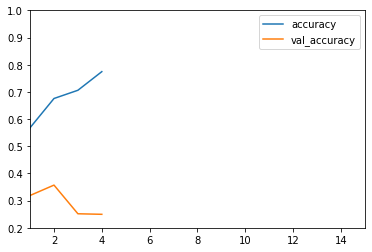

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(xlim=[1, 15], ylim=[0.2, 1])
plt.show()

In [ ]:
model.evaluate(test_ds)

78/78 [==============================] - 10s 123ms/step - loss: 27.3200 - accuracy: 0.2457


[27.31995391845703, 0.24567751586437225]

## DenseNet121

In [ ]:
test_ds, train_ds, valid_ds = load_data()

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [ ]:
test_ds, train_ds, valid_ds = custom_preprocess([test_ds, train_ds, valid_ds])
full_train_ds = valid_ds.concatenate(train_ds) # larger ds

In [ ]:
model = tf.keras.applications.DenseNet121( # less params
    include_top=True, weights=None, 
    input_shape=[240, 240, 3], classes=4,
)
model.compile(
    optimizer=keras.optimizers.Adam(0.02), 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4) 
history = model.fit(full_train_ds, epochs=20, 
                    callbacks=[early_stopping_cb], 
                    validation_data=test_ds)

Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(xlim=[1, 26], ylim=[0.2, 1])
plt.show()

## Custom ResNet 
much credit to Aurelien Geron; Hands on machine learning w/ scikit learn keras & tensorflow

In [ ]:
test_ds, train_ds, valid_ds = load_data(batch=13) # tiny batch size
test_ds, train_ds, valid_ds = custom_preprocess([test_ds, train_ds, valid_ds])
full_train_ds = valid_ds.concatenate(train_ds) 

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


image batch shape = (13, 240, 240, 3), label batch shape = (13,)


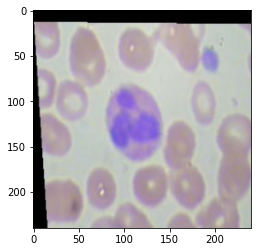

In [ ]:
for im_b, lab_b in train_ds: 
    print(f'image batch shape = {im_b.shape}, label batch shape = {lab_b.shape}')
    plt.imshow(im_b[0])
    break
plt.show() # consider resizing

In [ ]:
DefaultConv = partial(layers.Conv2D, kernel_size=3, strides=1, use_bias=False,
                        padding='same', kernel_initializer='he_normal')

class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.layers = [
            DefaultConv(filters, strides=strides),
            layers.BatchNormalization(),
            self.activation,
            DefaultConv(filters),
            layers.BatchNormalization()
        ]
        self.skip_layers = [
            # make sure skip connection gets scaled 
            DefaultConv(filters, strides=strides), 
            layers.BatchNormalization(),
        ]

    def call(self, inputs):
        Z = inputs
        for layer in self.layers:
            Z = layer(Z)
        Z_skip = inputs
        for skip_layer in self.skip_layers:
            Z_skip = skip_layer(Z_skip)
        return self.activation(Z + Z_skip)

def res18(input_shape, classes):
    # resnet 18, modified with dropout layers 
    # and less filters
    input = keras.Input(shape=input_shape)
    X = DefaultConv(64, kernel_size=7, strides=2)(input)
    X = layers.MaxPooling2D(3, strides=2)(X)
    
    # first residual pairs
    for _ in range(2):
        X = ResidualBlock(64)(X)  
    for _ in range(2):
        X = ResidualBlock(128)(X)
        
    # drop out and residual pair
    X = layers.Dropout(0.5)(X)
    X = ResidualBlock(256, strides=2)(X)
    X = ResidualBlock(256)(X)
    
    # drop out and large block ? (2)
    X = layers.Dropout(0.5)(X)
    X = ResidualBlock(512, strides=2)(X)
    
    # final pooling 
    X = layers.AveragePooling2D(2)(X)
    
    # FC layer & dropout for classification 
    X = layers.Flatten()(X)
    X = layers.Dense(10, kernel_initializer='he_normal', 
                        activation='relu')(X)
    X = layers.Dropout(0.5)(X)
    output = layers.Dense(classes, activation='softmax')(X)

    return keras.Model(inputs=input, outputs=output)

model = res18(input_shape=[240, 240, 3], classes=4)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 64)      9408      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 64)       0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  (None, 59, 59, 64)       111360    
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 59, 59, 64)       111360    
 lock)                                                           
                                                             

In [ ]:
from tensorflow.keras import backend as k
import gc

epochs = 15
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:

        y_pred = model(x, training=True)
        # print('logits = ', y_pred)
        # print('y shape', y, 'logits shape', y_pred)

        loss_value = loss_fn(y, y_pred) 
        # print('loss_value = ', loss_value)

    grads = tape.gradient(loss_value, model.trainable_weights)
    # print('grads = ', grads)

    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # print('applied grads')

    acc_metric.update_state(y, y_pred)
    # print('got accuracy metric')

    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

for epoch in range(1, epochs + 1):
    print(f'\n\n=========== Start of epoch {epoch}/{epochs}')

    # train loop
    for step, (x_batch, y_batch) in enumerate(full_train_ds):
        loss = train_step(x_batch, y_batch)
        if step % 50 == 0:
            print(f'train loss at batch step {step}: {loss:.4f}')

        # force garbage collection
        gc.collect()
        k.clear_session()

    # log train accuracy
    train_acc = acc_metric.result()
    print(f'\t>test accuracy: {train_acc:.4f}')
    acc_metric.reset_states()

    # validation loop
    for step, (x_batch, y_batch) in enumerate(test_ds):
        loss = test_step(x_batch, y_batch)

    # log test accuracy
    train_acc = val_acc_metric.result()
    print(f'\t>train accuracy: {train_acc:.4f}')
    val_acc_metric.reset_states()



=========== Start of epoch 1/15
train loss at batch step 0: 1.3055
train loss at batch step 50: 1.3907
train loss at batch step 100: 1.3917
train loss at batch step 150: 1.3877
train loss at batch step 200: 1.3899


# TODO
sparse is for onehot

In [ ]:
# change to batch
class MemoryCallback(K.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)